In [57]:
# Packages for neural networks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas
import seaborn

In [2]:
# Have the Data then convert them into hourly data. 
def hourly(weather):
    minute = 0
    Hourly = np.zeros((8760, 4))
    hour = 0
    endminute = 60
    while (minute < len(weather[:, 3]) and hour < 8760):
        temp = np.nanmean(weather[np.arange(minute, endminute), 0])
        relhum = np.nanmean(weather[np.arange(minute, endminute), 1])
        air_p = np.nanmean(weather[np.arange(minute, endminute), 2])
        precip = np.nansum(weather[np.arange(minute, endminute), 3])
        if (minute+60 < len(weather[:, 3])):
            minute += 60
        if (minute+60 < len(weather[:, 3])):
            endminute = minute + 60
        else:
            endminute = len(weather[:, 3])
        Hourly[hour, 0] = temp
        Hourly[hour, 1] = relhum
        Hourly[hour, 2] = air_p
        Hourly[hour, 3] = precip
        hour += 1
    
    return Hourly

In [4]:
# Upload data
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [5]:
# Get Data for the completed years of 2018, 2019, and 2020
Whole18 = histplot.getData(18, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole19 = histplot.getData(19, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole20 = histplot.getData(20, direct, ASC, 1, 366, np.arange(3, 7), float)

In [12]:
hour18 = hourly(Whole18)
hour19 = hourly(Whole19)
hour20 = hourly(Whole20)


In [10]:
# Periodicity of Time 
day = 24*60*60 # Number in seconds
year = (365.2425)*day # Number in seconds



In [20]:
hour_all = np.concatenate([hour18, hour19, hour20], axis = 0)
hour_all.shape

(26280, 4)

In [21]:
len(hour_all)

26280

In [49]:
new_hour = pandas.DataFrame(hour_all)

In [50]:
new_hour = new_hour.rename({0: "Temperature ($^\circ C$)", 1 : "Relative Humidity (%)", 2: "Atmospheric Pressure (bar)", 3: "Precipitation (mm)"}, axis = 'columns')
new_hour

,Temperature ($^\circ C$),Relative Humidity (%),Atmospheric Pressure (bar),Precipitation (mm)
0,-10.955000,45.361667,1.017778,0.0
1,-11.401667,46.405000,1.017877,0.0
2,-11.616667,47.426667,1.018020,0.0
3,-11.930000,48.390000,1.018145,0.0
4,-12.368333,49.235000,1.018128,0.0
...,...,...,...,...
26275,5.088333,42.065000,1.016072,0.0
26276,5.028333,43.433333,1.015270,0.0
26277,4.566667,47.421667,1.014422,0.0
26278,4.046667,50.323333,1.013760,0.0


In [52]:
column_indices = {name: i for i, name in enumerate(new_hour.columns)}

n = len(new_hour)
train_df = new_hour[0:int(n*0.7)]
val_df = new_hour[int(n*0.7):int(n*0.9)]
test_df = new_hour[int(n*0.9):]

num_features = new_hour.shape[1]

In [53]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

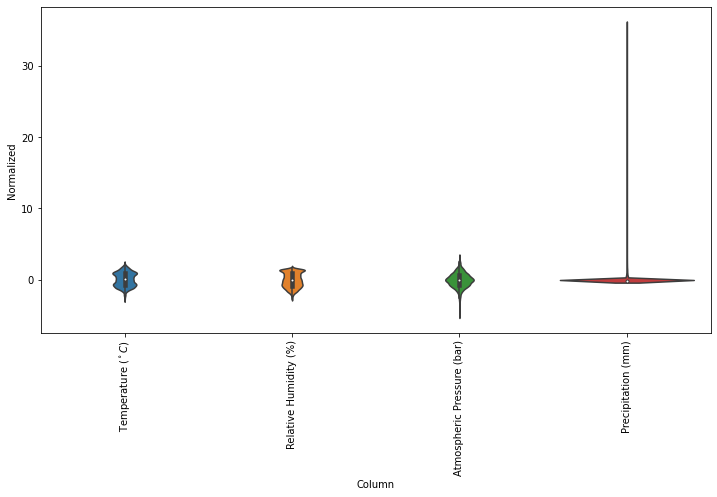

In [58]:
df_std = (new_hour - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = seaborn.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(new_hour.keys(), rotation=90)

In [65]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    
    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [70]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Temperature ($^\circ C$)'])
w1


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Temperature ($^\\circ C$)']

In [71]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Temperature ($^\circ C$)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Temperature ($^\\circ C$)']

In [72]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [73]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 4)
Inputs shape: (3, 6, 4)
labels shape: (3, 1, 1)


In [74]:
w2.example = example_inputs, example_labels

In [87]:
def plot(self, model=None, plot_col='Temperature ($^\circ C$)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')
WindowGenerator.plot = plot

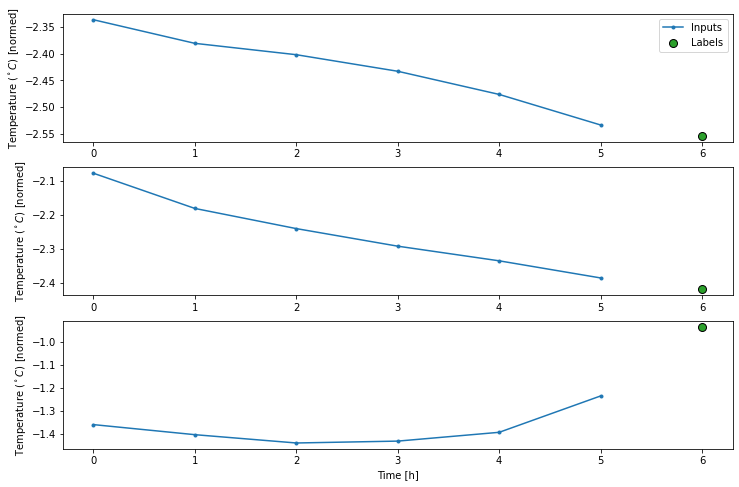

In [88]:
w2.plot()


In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset